**Evaluating GOES images with coincident MODIS and ASTER**

What are the magnitude and distribution of differences between ABI-ASTER & MODIS-ASTER?
* Is there an East-to-West change in differences?
* Is there a North-to-South change in differences?
* Is there a relationship between differences and elevation, slope, or aspect?
* Is there a relationship between differences and fractional vegetation covered area?

In [147]:
import xarray as xr
from xhistogram.xarray import histogram
import richdem as rd
import rioxarray as rxr
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [148]:
import warnings
warnings.filterwarnings('ignore')

Define functions

In [3]:
def summary_stats(a, b):
    '''Compute summary statistics for the difference between two sets.
    Input two flattened (1-D) arrays with NaN values removed'''
    
    # remove nan values
    a = a[np.isnan(a)==False]
    b = b[np.isnan(b)==False]
    
    # for difference stats
    diff = b - a
    
    # for linear regression stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(a, b)
    
    # populate dict with summary stats
    summary_stats_dict = {
        #'diff' : diff ,
        'n' : len(diff) ,
        'mean_diff' : np.nanmean( diff ),
        'median_diff' : np.nanmedian( diff ),
        'mean_squared_diff' : np.nanmean( diff**2 ),
        'rms_diff' : np.sqrt( np.nanmean( diff**2 ) ),
        'std_diff' : np.nanstd( diff ),
        'slope' : slope,
        'intercept' : intercept,
        'r_value' : r_value,
        'p_value' : p_value,
        'std_err' : std_err
        }
    
    return summary_stats_dict

---
Read in the ground based data timeseries for Gaylor Pit and CUES sites

In [4]:
# Gaylor Pit
tuol_df = pd.read_pickle('data/goes-tuolumne_2017-2020.pkl')
tuol_df['timeUTC'] = tuol_df.index + pd.Timedelta(hours=8)
tuol_df.set_index('timeUTC',inplace=True)
tuol_ds = tuol_df.to_xarray().squeeze()

# CUES
cues_df = pd.read_pickle('data/goes-cues_2017-2020.pkl')
cues_df['timeUTC'] = cues_df.index + pd.Timedelta(hours=8)
cues_df.set_index('timeUTC',inplace=True)
cues_ds = cues_df.to_xarray().squeeze()

Set up working area geometry

In [5]:
# Larger area around Tuolumne further south and east to include Mammoth
(utm_e_UL, utm_n_UL) = 282500, 4205000
(utm_e_UR, utm_n_UR) = 305000, 4205000
(utm_e_LR, utm_n_LR) = 327500, 4160000
(utm_e_LL, utm_n_LL) = 305000, 4160000

geometry = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_e_UL, utm_n_UL],
            [utm_e_UR, utm_n_UR],
            [utm_e_LR, utm_n_LR],
            [utm_e_LL, utm_n_LL]
        ]]
    }
]

Find datasets

In [6]:
filepaths = glob.glob('/storage/spestana/output_ASTER-MODIS-GOES/*_orthorectified.nc')
#filepaths = glob.glob('/storage/spestana/output_ASTER-MODIS-GOES/*_original.nc')

Open all datasets

In [7]:
ds = xr.open_mfdataset(filepaths, concat_dim='time', combine='nested')
ds = ds.rio.clip(geometry)

Open my DEM, reproject to UTM, add to the dataset

In [8]:
dem = xr.open_rasterio('dem/tuolumne_cues_dem.tif').rio.reproject_match(ds)
ds['dem'] = dem.squeeze()

Compute slope and aspect and add to the dataset

In [9]:
dem_array = rd.rdarray(ds.dem.values, no_data=np.nan).squeeze()
slope = rd.TerrainAttribute(dem_array, attrib='slope_riserun')
ds['slope'] = (['y','x'], slope)
aspect = rd.TerrainAttribute(dem_array, attrib='aspect')
ds['aspect'] = (['y','x'], aspect)
# aspect looks like it puts 0=360 at East not north. 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


Open TCC and ad to the dataset

In [10]:
tcc = xr.open_rasterio('data/NLCD_2016_Tree_Canopy_L48_20190831_2xOlzdukUemPqURl8ckP.tiff').rio.reproject_match(ds)
ds['tcc'] = tcc.squeeze()
fveg = (tcc - tcc.min()) / (tcc.max() - tcc.min()) # normalizing tcc to get fveg
ds['fveg'] = fveg.squeeze()

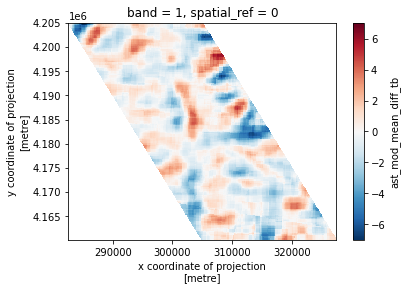

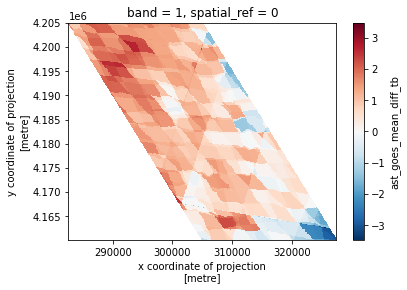

In [11]:
plt.figure()
ds.ast_mod_mean_diff_tb.mean(axis=0).plot()

plt.figure()
ds.ast_goes_mean_diff_tb.mean(axis=0).plot()

In [81]:
def fveg_mapZonalStats(zones, zonalstats, stat_name):
    ''' Function for mapping the zonal statistics back to the original grid to get a 2D map of the chosen statistic'''
    # create an empty array for this summary stat
    zonal_stat = np.zeros_like(zones.values, dtype=np.float64)

    # for each zone
    for zone_n in zonalstats.index.values:
        # get the summary stat for that zone, 
        # and assign it to the correct locations in the zonal_stat array
        #try:
        zonal_stat[zones.values==zone_n] = zonalstats['{}'.format(stat_name)].loc[zone_n]
        #except: #MaskError: Cannot convert masked element to a Python int.
        #    zonal_stat[zones.values==zone_n] = -9999

    # convert this to an xarray data array with the proper name
    zonal_stat_da = xr.DataArray(zonal_stat, 
                                 dims=["y", "x"],
                                 coords=dict(
                                             x=(["x"], zones.x),
                                             y=(["y"], zones.y),
                                             ),
                                 name='zonal_{}'.format(stat_name))
    # remove nodata values
    zonal_stat_da = zonal_stat_da.where(zonal_stat_da!=-9999, np.nan)

    return zonal_stat_da     

In [116]:
da_fveg_mean_stack = []
for i in range(0,len(ds.time)):
    fveg_mean = ds.isel(time=i).groupby('ast_goes_goes_zones').mean().fveg.drop(['spatial_ref','band','time']).to_dataframe()
    da_fveg_mean = fveg_mapZonalStats(ds.isel(time=i).ast_goes_goes_zones, fveg_mean, 'fveg')
    da_fveg_mean_stack.append(da_fveg_mean)

In [117]:
ds_fveg_mean = xr.concat(da_fveg_mean_stack, 'time' )

In [122]:
ds['zonal_mean_fveg'] = ds_fveg_mean

Text(0.5, 1.0, '')

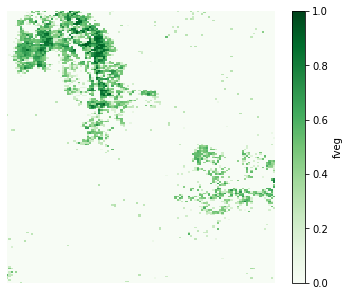

In [341]:
plt.figure(figsize=(6,5))
ds.fveg.plot(cmap='Greens')
plt.xlim((297250,308000))
plt.ylim((4175000,4190000))
plt.axis('off')
plt.title('')

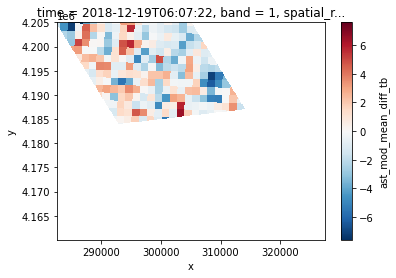

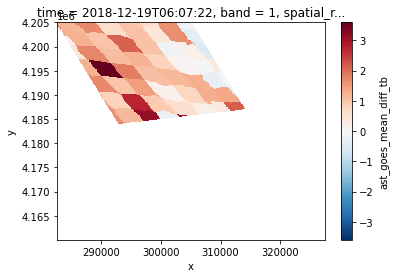

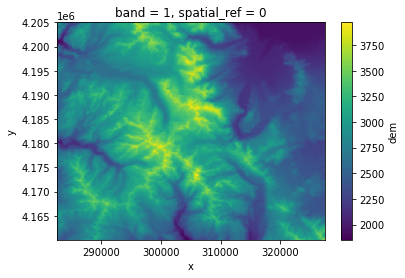

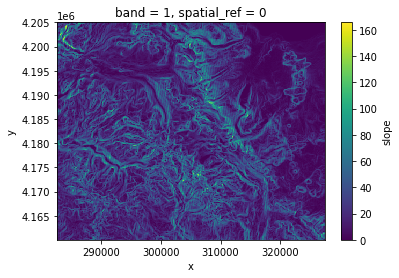

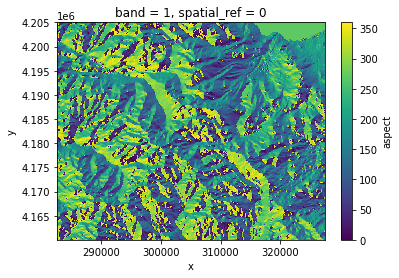

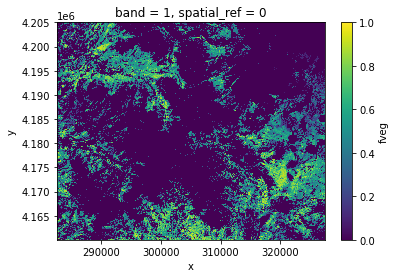

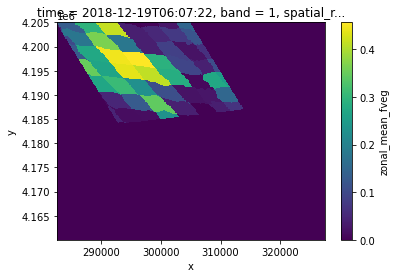

In [123]:
plt.figure()
ds.isel(time=10).ast_mod_mean_diff_tb.plot()

plt.figure()
ds.isel(time=10).ast_goes_mean_diff_tb.plot()

plt.figure()
ds.dem.plot()

plt.figure()
ds.slope.plot()

plt.figure()
ds.aspect.plot()

plt.figure()
ds.fveg.plot()

plt.figure()
ds.isel(time=10).zonal_mean_fveg.plot()

In [262]:
ds.to_netcdf('/storage/spestana/ASTER-MODIS-GOES-DEM-FVEG_orthorectified.nc')

---
---

### Elevation

<>:14: DeprecationWarning: invalid escape sequence \D
<>:15: DeprecationWarning: invalid escape sequence \D
<>:28: DeprecationWarning: invalid escape sequence \D
<>:29: DeprecationWarning: invalid escape sequence \D
<>:42: DeprecationWarning: invalid escape sequence \D
<>:43: DeprecationWarning: invalid escape sequence \D
<>:14: DeprecationWarning: invalid escape sequence \D
<>:15: DeprecationWarning: invalid escape sequence \D
<>:28: DeprecationWarning: invalid escape sequence \D
<>:29: DeprecationWarning: invalid escape sequence \D
<>:42: DeprecationWarning: invalid escape sequence \D
<>:43: DeprecationWarning: invalid escape sequence \D
<>:14: DeprecationWarning: invalid escape sequence \D
<>:15: DeprecationWarning: invalid escape sequence \D
<>:28: DeprecationWarning: invalid escape sequence \D
<>:29: DeprecationWarning: invalid escape sequence \D
<>:42: DeprecationWarning: invalid escape sequence \D
<>:43: DeprecationWarning: invalid escape sequence \D
<ipython-input-144-511b9cbc9

Text(0.5, 1.0, '|ABI-ASTER $\\Delta T$| $[\\degree C]$\nversus Elevation [m]')

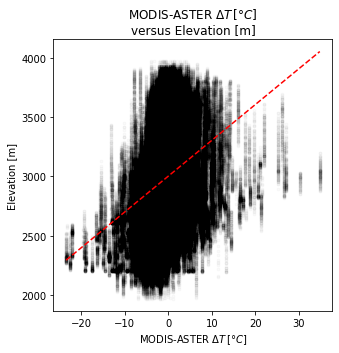

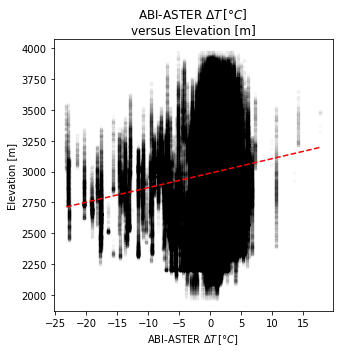

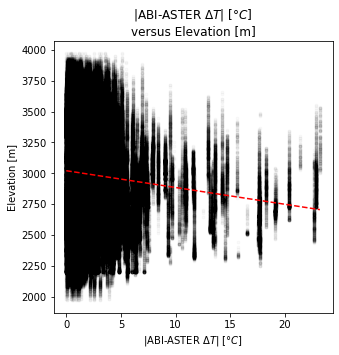

In [144]:
y = np.array([ds.dem.values] * 27).ravel()

# MODIS-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_mod_mean_diff_tb.values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Elevation [m]')
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.title('MODIS-ASTER $\Delta T\,[\degree C]$\nversus Elevation [m]')

# ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_goes_mean_diff_tb.values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Elevation [m]')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus Elevation [m]')

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Elevation [m]')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus Elevation [m]')

Text(0.5, 1.0, '|ABI-ASTER $\\Delta T$| $[\\degree C]$\nversus Elevation [m]')

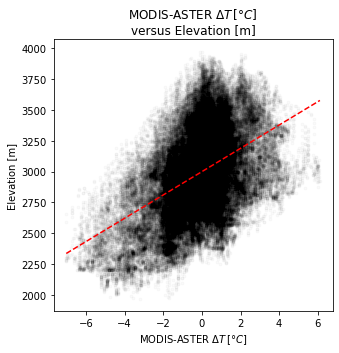

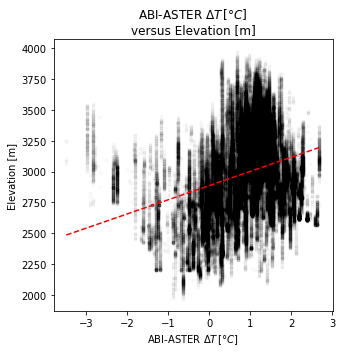

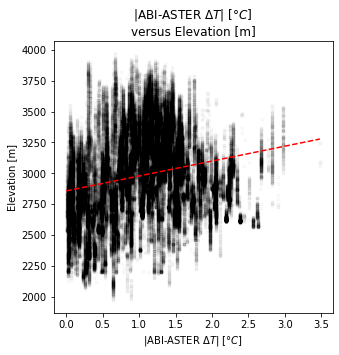

In [149]:
y = ds.dem.values.ravel()

# MODIS-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Elevation [m]')
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.title('MODIS-ASTER $\Delta T\,[\degree C]$\nversus Elevation [m]')

# ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Elevation [m]')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus Elevation [m]')

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = np.abs(ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel())
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Elevation [m]')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus Elevation [m]')

### Slope

<>:14: DeprecationWarning: invalid escape sequence \D
<>:15: DeprecationWarning: invalid escape sequence \D
<>:28: DeprecationWarning: invalid escape sequence \D
<>:29: DeprecationWarning: invalid escape sequence \D
<>:42: DeprecationWarning: invalid escape sequence \D
<>:43: DeprecationWarning: invalid escape sequence \D
<>:14: DeprecationWarning: invalid escape sequence \D
<>:15: DeprecationWarning: invalid escape sequence \D
<>:28: DeprecationWarning: invalid escape sequence \D
<>:29: DeprecationWarning: invalid escape sequence \D
<>:42: DeprecationWarning: invalid escape sequence \D
<>:43: DeprecationWarning: invalid escape sequence \D
<>:14: DeprecationWarning: invalid escape sequence \D
<>:15: DeprecationWarning: invalid escape sequence \D
<>:28: DeprecationWarning: invalid escape sequence \D
<>:29: DeprecationWarning: invalid escape sequence \D
<>:42: DeprecationWarning: invalid escape sequence \D
<>:43: DeprecationWarning: invalid escape sequence \D
<ipython-input-143-1ea178cf5

Text(0.5, 1.0, '|ABI-ASTER $\\Delta T$| $[\\degree C]$\nversus Slope')

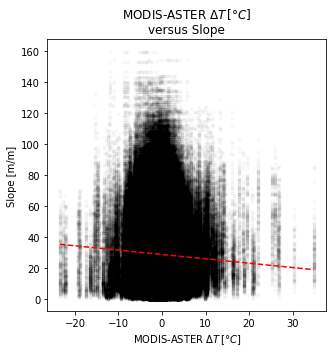

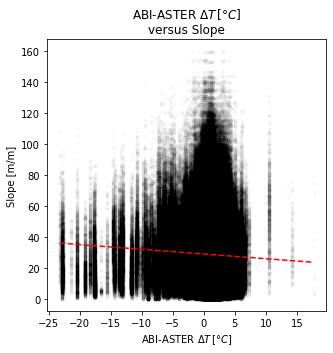

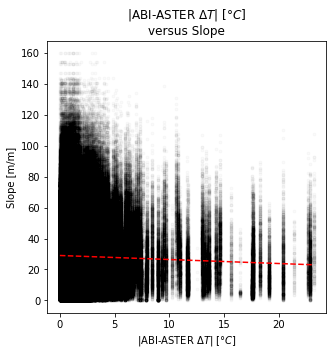

In [143]:
y = np.array([ds.slope.values] * 27).ravel()

# MODIS-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_mod_mean_diff_tb.values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Slope [m/m]')
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.title('MODIS-ASTER $\Delta T\,[\degree C]$\nversus Slope')

# ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_goes_mean_diff_tb.values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Slope [m/m]')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus Slope')

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Slope [m/m]')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus Slope')

Text(0.5, 1.0, '|ABI-ASTER $\\Delta T$| $[\\degree C]$\nversus Slope')

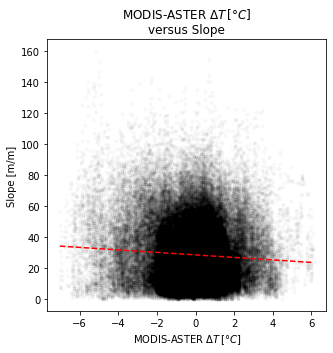

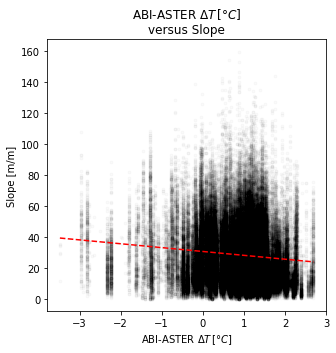

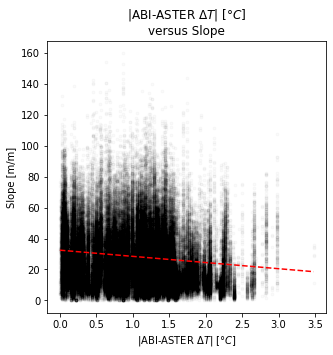

In [150]:
y = ds.slope.values.ravel()

# MODIS-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Slope [m/m]')
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.title('MODIS-ASTER $\Delta T\,[\degree C]$\nversus Slope')

# ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Slope [m/m]')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus Slope')

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = np.abs(ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel())
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Slope [m/m]')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus Slope')

### Aspect

<>:13: DeprecationWarning: invalid escape sequence \d
<>:14: DeprecationWarning: invalid escape sequence \D
<>:15: DeprecationWarning: invalid escape sequence \D
<>:27: DeprecationWarning: invalid escape sequence \d
<>:28: DeprecationWarning: invalid escape sequence \D
<>:29: DeprecationWarning: invalid escape sequence \D
<>:41: DeprecationWarning: invalid escape sequence \d
<>:42: DeprecationWarning: invalid escape sequence \D
<>:43: DeprecationWarning: invalid escape sequence \D
<>:13: DeprecationWarning: invalid escape sequence \d
<>:14: DeprecationWarning: invalid escape sequence \D
<>:15: DeprecationWarning: invalid escape sequence \D
<>:27: DeprecationWarning: invalid escape sequence \d
<>:28: DeprecationWarning: invalid escape sequence \D
<>:29: DeprecationWarning: invalid escape sequence \D
<>:41: DeprecationWarning: invalid escape sequence \d
<>:42: DeprecationWarning: invalid escape sequence \D
<>:43: DeprecationWarning: invalid escape sequence \D
<>:13: DeprecationWarning: i

Text(0.5, 1.0, '|ABI-ASTER $\\Delta T$| $[\\degree C]$\nversus Aspect')

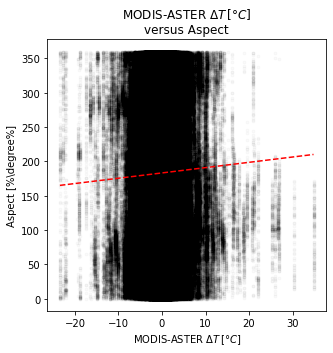

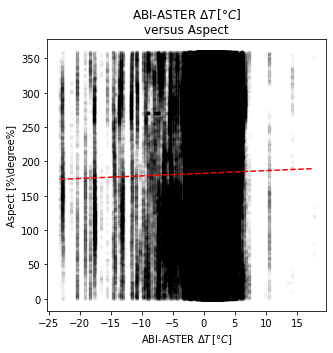

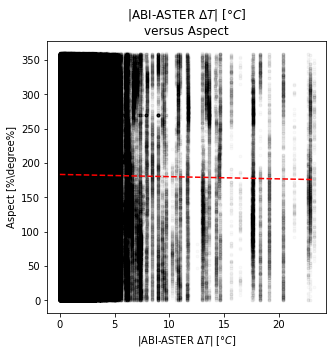

In [142]:
y = np.array([ds.aspect.values] * 27).ravel()

# MODIS-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_mod_mean_diff_tb.values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Aspect [%\degree%]')
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.title('MODIS-ASTER $\Delta T\,[\degree C]$\nversus Aspect')

# ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_goes_mean_diff_tb.values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Aspect [%\degree%]')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus Aspect')

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Aspect [%\degree%]')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus Aspect')

Text(0.5, 1.0, '|ABI-ASTER $\\Delta T$| $[\\degree C]$\nversus Aspect')

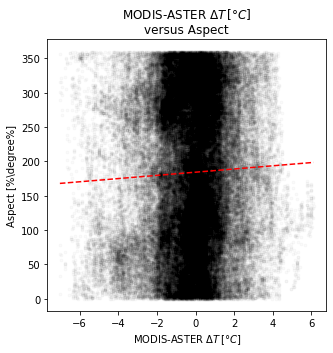

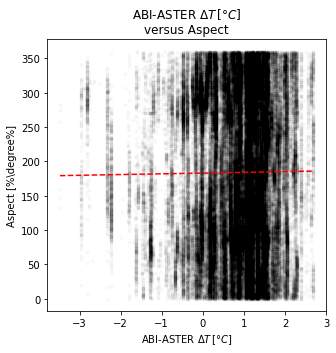

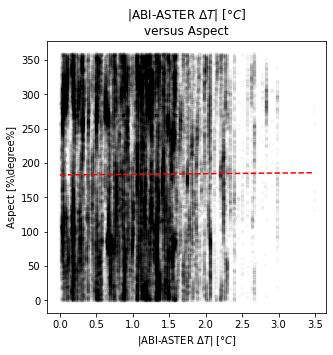

In [151]:
y = ds.aspect.values.ravel()

# MODIS-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Aspect [%\degree%]')
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.title('MODIS-ASTER $\Delta T\,[\degree C]$\nversus Aspect')

# ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Aspect [%\degree%]')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus Aspect')

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = np.abs(ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel())
plt.scatter(x,y,marker='.',c='k',alpha=0.02)
_x = x[~np.isnan(x)]
_y = y[~np.isnan(x)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('Aspect [%\degree%]')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus Aspect')

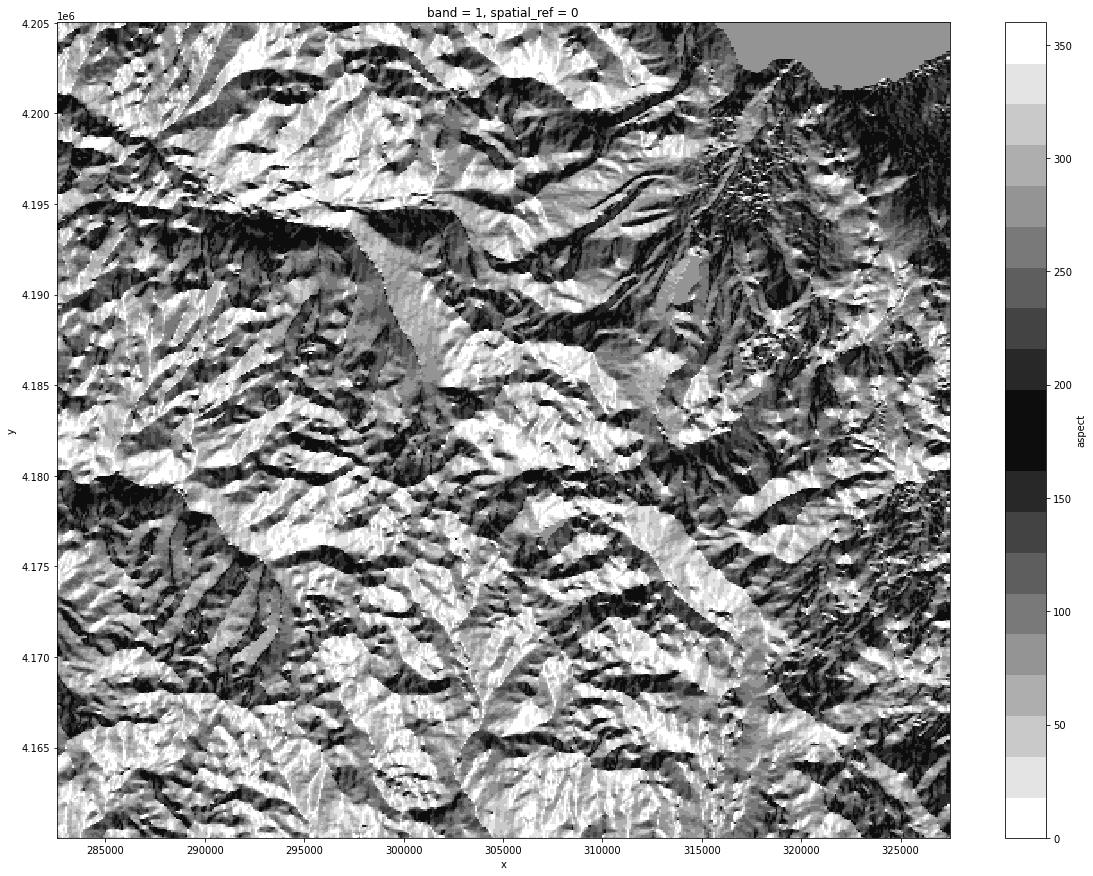

In [300]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(1,1,1), (0, 0, 0), (1,1,1)]  # R -> G -> B

cmap = LinearSegmentedColormap.from_list('mycmap', colors, N=20)

plt.figure(figsize=(20,15))
ds.aspect.plot(cmap=cmap)

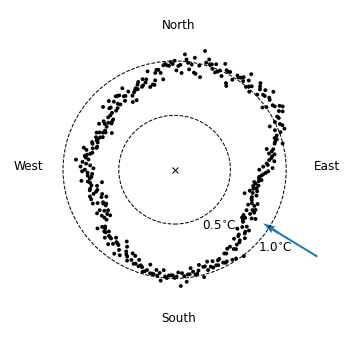

In [324]:
def pol2cart(rho, phi, rotate):
    # given a point's polar coordinates rho (radial distance), phi (clockwise azimuth angle), 
    # and rotate (angle to add to phi to put 0 degrees at the top like a compass)
    #https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates
    x = rho * np.cos(np.radians(-phi+rotate))
    y = rho * np.sin(np.radians(-phi+rotate))
    return(x, y)

azis = np.array([ds.aspect.values]*27).ravel() # azimuth angles these are oriented with 0 as south, 180 as north
temps = ds.ast_goes_mean_diff_tb.values.ravel() # temperatures

#azis = ds.aspect.values.ravel() # azimuth angles
#temps = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel() # temperatures


rotate = -90 # rotate 90 for 0 at top, rotate -90 for 0 at bottom 

# for all data
x,y = pol2cart(temps,azis,rotate) 

# average by 10 degree bins
azis_1deg = np.round(azis,0)
temps_1deg = []
for a in range(0,360):
    temps_1deg.append(np.nanmean(temps[azis_1deg == a]))
x_1deg,y_1deg = pol2cart(temps_1deg,np.array(range(0,360)),rotate) 

fig,ax = plt.subplots(figsize=(6,6))

ax.plot(0,0,'x',color='k')
circle0p5 = plt.Circle((0, 0), 0.5, color='k', fill=False, linestyle='--')
circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
circle1p5 = plt.Circle((0, 0), 1.5, color='k', fill=False, linestyle='--')

ax.add_artist(circle0p5)
ax.add_artist(circle1)
#ax.add_artist(circle1p5)

plt.text(.25,-.55,'0.5$^{\circ}$C',color='k',fontsize=12)
plt.text(.75,-.75,'1.0$^{\circ}$C',color='k',fontsize=12)
#plt.text(1.2,-1.1,'1.5$^{\circ}$C',color='k',fontsize=12)


north_x, north_y = pol2cart(1.3,175,rotate)
south_x, south_y = pol2cart(1.4,5,rotate)
east_x, east_y = pol2cart(1.25,270,rotate)
west_x, west_y = pol2cart(1.44,90,rotate)
plt.text(north_x,north_y,'North',fontsize=12)
plt.text(south_x,south_y,'South',fontsize=12)
plt.text(east_x,east_y,'East',fontsize=12)
plt.text(west_x,west_y,'West',fontsize=12)

#ax.scatter(x,y,s=5,alpha=0.3,facecolors='tab:gray', edgecolors='none',label='Temperature per 1$^{\circ}$ azimuth bin');
ax.scatter(x_1deg,y_1deg,s=15,alpha=1,facecolors='k', edgecolors='none',zorder=3,label='Mean Temperature per 1$^{\circ}$ azimuth bin');
#ax.plot(x_1deg,y_1deg,markersize=10,alpha=1, linestyle='-',c='r', zorder=3,label='Mean Temperature per 1$^{\circ}$ azimuth bin');
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))
plt.axis('off')
#plt.legend(loc='lower right')
#plt.savefig('polar_plot_mean_vs_AzimuthAngle_all_greaterthan1C.png',dpi=600)


# Direction of GOES-16's view is about 122 degrees (when north is 0), but here with south as 0, that is 180+122 = 302
sun_x, sun_y = pol2cart(1.5,302,rotate)
sun_x2, sun_y2 = pol2cart(1.1,302,rotate)
plt.quiver(sun_x2,sun_y2,-sun_x2,-sun_y2,color='tab:blue',label='GOES-16 ABI')
plt.plot([sun_x,sun_x2],[sun_y,sun_y2],'-',linewidth='2',color='tab:blue')

### Fveg (zeros removed)

<>:16: DeprecationWarning: invalid escape sequence \D
<>:17: DeprecationWarning: invalid escape sequence \D
<>:32: DeprecationWarning: invalid escape sequence \D
<>:33: DeprecationWarning: invalid escape sequence \D
<>:48: DeprecationWarning: invalid escape sequence \D
<>:49: DeprecationWarning: invalid escape sequence \D
<>:16: DeprecationWarning: invalid escape sequence \D
<>:17: DeprecationWarning: invalid escape sequence \D
<>:32: DeprecationWarning: invalid escape sequence \D
<>:33: DeprecationWarning: invalid escape sequence \D
<>:48: DeprecationWarning: invalid escape sequence \D
<>:49: DeprecationWarning: invalid escape sequence \D
<>:16: DeprecationWarning: invalid escape sequence \D
<>:17: DeprecationWarning: invalid escape sequence \D
<>:32: DeprecationWarning: invalid escape sequence \D
<>:33: DeprecationWarning: invalid escape sequence \D
<>:48: DeprecationWarning: invalid escape sequence \D
<>:49: DeprecationWarning: invalid escape sequence \D
<ipython-input-140-09eb5da84

Text(0.5, 1.0, '|ABI-ASTER $\\Delta T$| $[\\degree C]$\nversus $F_{veg}$')

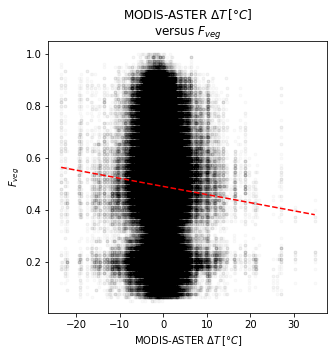

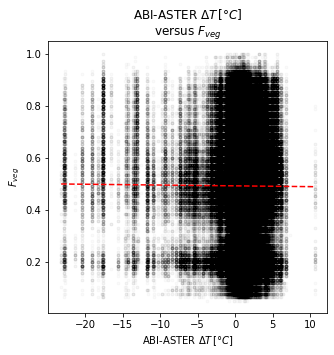

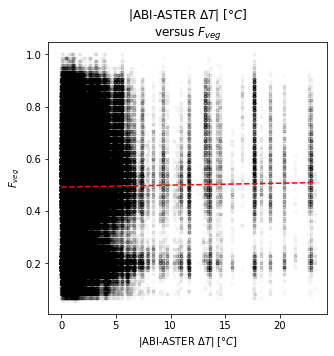

In [140]:
y = np.array([ds.fveg.values] * 27).ravel()

# MODIS-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_mod_mean_diff_tb.values.ravel()
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.02)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.title('MODIS-ASTER $\Delta T\,[\degree C]$\nversus $F_{veg}$')

# ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_goes_mean_diff_tb.values.ravel()
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.02)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus $F_{veg}$')

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.02)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus $F_{veg}$')

Text(0.5, 1.0, '|ABI-ASTER $\\Delta T$| $[\\degree C]$\nversus $F_{veg}$')

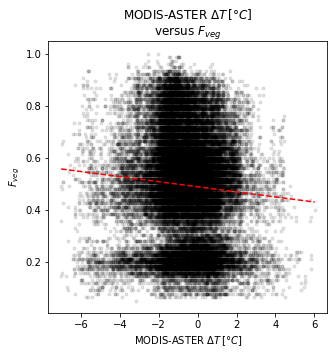

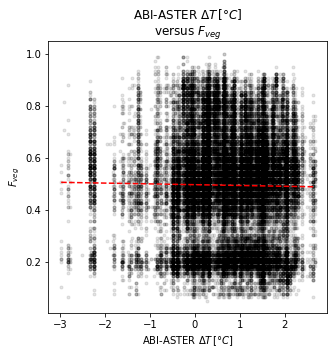

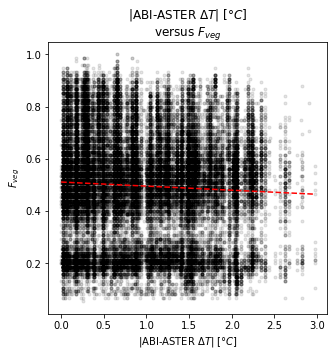

In [317]:
y = ds.fveg.values.ravel()

# MODIS-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.1)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('MODIS-ASTER $\Delta T\,[\degree C]$')
plt.title('MODIS-ASTER $\Delta T\,[\degree C]$\nversus $F_{veg}$')

# ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.1)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus $F_{veg}$')

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = np.abs(ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel())
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.1)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus $F_{veg}$')

### Zonal mean fveg

Text(0.5, 1.0, '|ABI-ASTER $\\Delta T$| $[\\degree C]$\nversus $F_{veg}$')

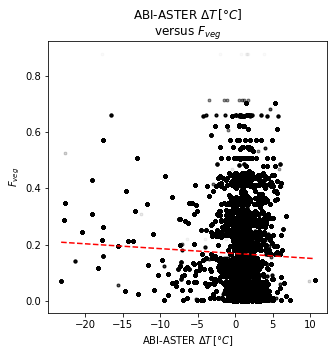

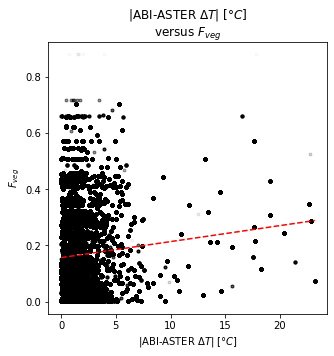

In [325]:
y = ds.zonal_mean_fveg.values.ravel()

# ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_goes_mean_diff_tb.values.ravel()
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.02)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus $F_{veg}$')

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.02)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus $F_{veg}$')

Text(0.5, 1.0, '|ABI-ASTER $\\Delta T$| $[\\degree C]$\nversus $F_{veg}$')

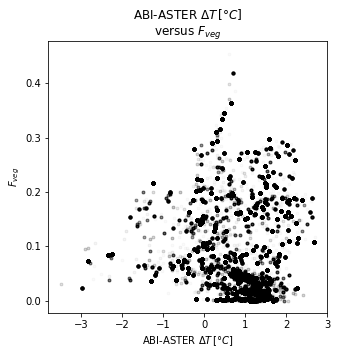

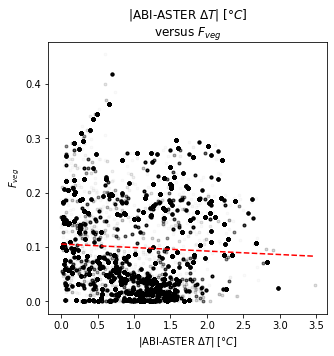

In [327]:
y = ds.zonal_mean_fveg.mean(axis=0).values.ravel()



# ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.02)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
#plt.plot(np.linspace(_x.min(),_x.max()),
#         slope*np.linspace(_x.min(),_x.max())+intercept,
#         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('ABI-ASTER $\Delta T\,[\degree C]$')
plt.title('ABI-ASTER $\Delta T\,[\degree C]$\nversus $F_{veg}$')

# Absolute value of ABI-ASTER deltaT
plt.figure(figsize=(5,5))
x = np.abs(ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel())
x0 = x[y!=0]
y0 = y[y!=0]
plt.scatter(x0,y0,marker='.',c='k',alpha=0.02)
_x = x0[~np.isnan(x0)]
_y = y0[~np.isnan(x0)]
slope, intercept, r, p, se = stats.linregress(_x, _y)
plt.plot(np.linspace(_x.min(),_x.max()),
         slope*np.linspace(_x.min(),_x.max())+intercept,
         '--r',zorder=99)
plt.ylabel('$F_{veg}$')
plt.xlabel('|ABI-ASTER $\Delta T$| $[\degree C]$')
plt.title('|ABI-ASTER $\Delta T$| $[\degree C]$\nversus $F_{veg}$')

---
---

---
---